In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [12]:
def load_credit_g():
    data = fetch_openml(name="credit-g", version=1, as_frame=True)
    df = data.frame.copy()
    df["target"] = (df["class"] == "good").astype(int)
    df.drop(columns=["class"], inplace=True)
    return df

df = load_credit_g()
df.head()


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,1
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,0
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,1
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,1
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,0


In [13]:
def build_preprocessing_pipeline(df):
    numeric_cols = df.select_dtypes(include=["number"]).drop(columns="target").columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_pipeline, numeric_cols),
        ("cat", cat_pipeline, cat_cols)
    ])
    return preprocessor

preprocessor = build_preprocessing_pipeline(df)


In [14]:
X = df.drop(columns=["target"])
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [15]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, solver="saga")
lr_params = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "class_weight": [None, "balanced"]
}

lr_gs = GridSearchCV(lr, lr_params, cv=cv, scoring="roc_auc", n_jobs=-1)
lr_gs.fit(X_train_prep, y_train)
lr_best = lr_gs.best_estimator_

print("Best Logistic Regression Params:", lr_gs.best_params_)


Best Logistic Regression Params: {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}


In [16]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt_params = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "class_weight": [None, "balanced"]
}

dt_gs = GridSearchCV(dt, dt_params, cv=cv, scoring="roc_auc", n_jobs=-1)
dt_gs.fit(X_train_prep, y_train)
dt_best = dt_gs.best_estimator_

print("Best Decision Tree Params:", dt_gs.best_params_)


Best Decision Tree Params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 10}


In [17]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "class_weight": [None, "balanced"]
}

rf_gs = GridSearchCV(rf, rf_params, cv=cv, scoring="roc_auc", n_jobs=-1)
rf_gs.fit(X_train_prep, y_train)
rf_best = rf_gs.best_estimator_

print("Best Random Forest Params:", rf_gs.best_params_)


Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}



=== Logistic Regression (Test Set) ===
ROC-AUC: 0.7742857142857142
              precision    recall  f1-score   support

           0       0.61      0.52      0.56        60
           1       0.81      0.86      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.69      0.69       200
weighted avg       0.75      0.76      0.75       200



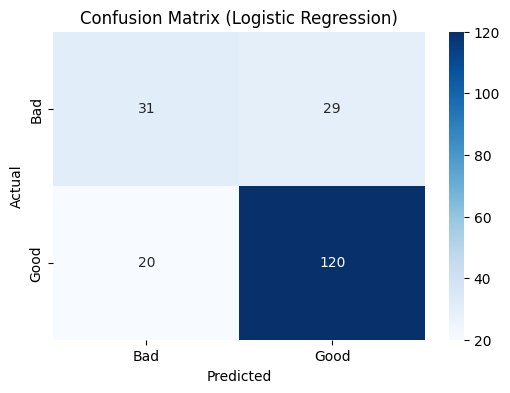


=== Decision Tree (Test Set) ===
ROC-AUC: 0.7151190476190477
              precision    recall  f1-score   support

           0       0.45      0.75      0.56        60
           1       0.85      0.61      0.71       140

    accuracy                           0.65       200
   macro avg       0.65      0.68      0.64       200
weighted avg       0.73      0.65      0.66       200



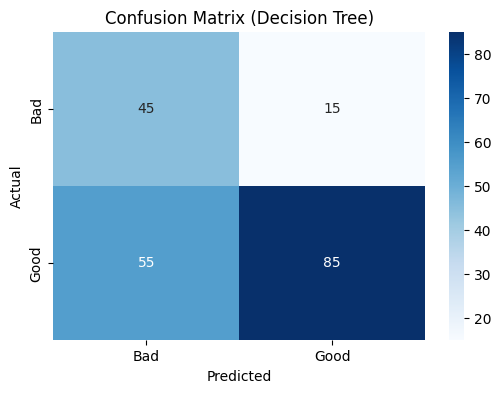


=== Random Forest (Test Set) ===
ROC-AUC: 0.7807142857142857
              precision    recall  f1-score   support

           0       0.52      0.55      0.54        60
           1       0.80      0.79      0.79       140

    accuracy                           0.71       200
   macro avg       0.66      0.67      0.67       200
weighted avg       0.72      0.71      0.72       200



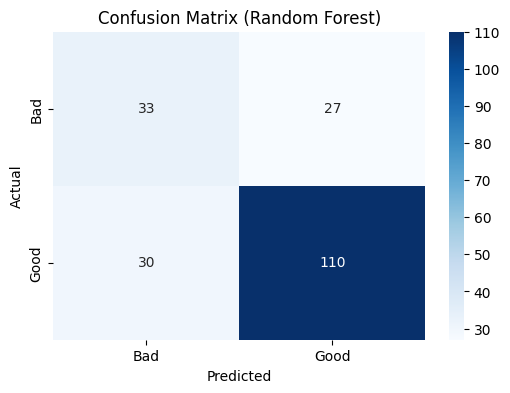

In [18]:
# Comparision
models = {
    "Logistic Regression": lr_best,
    "Decision Tree": dt_best,
    "Random Forest": rf_best
}

for name, model in models.items():
    probs = model.predict_proba(X_test_prep)[:, 1]
    preds = model.predict(X_test_prep)

    print(f"\n=== {name} (Test Set) ===")
    print("ROC-AUC:", roc_auc_score(y_test, probs))
    print(classification_report(y_test, preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({name})")
    plt.show()


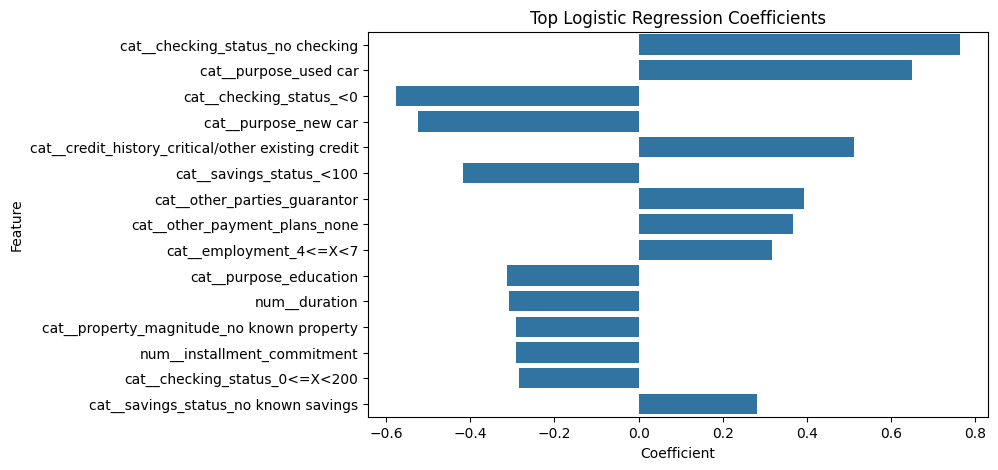

In [19]:
# Logistic Regression feature importance
feature_names = preprocessor.get_feature_names_out()
coefs = lr_best.coef_[0]
sorted_idx = np.argsort(np.abs(coefs))[::-1][:15]

plt.figure(figsize=(8, 5))
sns.barplot(x=coefs[sorted_idx], y=np.array(feature_names)[sorted_idx])
plt.title("Top Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()
